# Aim

The aim of the anaylsis is to get basic cNE properties and compare properties of cNEs in A1 and MGB

In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal, stats
from scipy.stats import zscore
from plot_box import plot_significance_star
from ne_toolbox import moran_i, calc_strf_ptd



# get colors for box plots
colors = sns.color_palette("Paired")
A1_color = (colors[1], colors[0], colors[3], colors[2])
MGB_color = (colors[5], colors[4], colors[7], colors[6])
colors = list(MGB_color) + list(A1_color)

In [2]:
datafolder = 'E:\Congcong\Documents\data\comparison\data-summary'
ne_file = os.path.join(datafolder, 'cNE.json')
ne = pd.read_json(ne_file)
su = pd.read_json(os.path.join(datafolder, 'single_units.json'))

In [3]:
ne.head()

,exp,probe,depth,cNE,members,pattern,strf_sig,crh_sig,freq_span_oct,region
0,191126211411,H31x64,5214,0,"[3, 4, 9]","[-0.0756121417, 0.0515729986, 0.0342513859, 0....",True,False,3.211138,MGB
1,191126211411,H31x64,5214,1,"[1, 8, 10]","[0.2273610862, 0.2949384624, 0.240309528300000...",False,True,3.010442,MGB
2,191126211411,H31x64,5214,2,"[1, 5, 7]","[0.0742804231, 0.45692949320000004, -0.4728641...",True,True,2.107309,MGB
3,200127153707,H31x64,5004,0,"[0, 3, 6]","[0.4240616038, 0.09859236900000001, 0.26063851...",False,False,2.207657,MGB
4,200709232021,H22x32,1300,0,"[7, 13, 16, 20]","[0.047847763700000004, 0.08136203630000001, 0....",True,True,0.401392,A1


### Add Features (Run Once)

In [4]:
# add frequency span of all members
freq_span = []
su_sig = su[su.strf_sig]
for i in range(len(ne)):
    cNE = ne.iloc[i]
    exp = cNE.exp
    probe = cNE.probe
    members = su_sig[(su_sig.exp == exp) & (su_sig.probe == probe)]
    members = members[members['index'].apply(lambda x: x in cNE.members)]
    # get frequency span of members
    if len(members) > 1:
        freq_span.append(np.log2(members.bf.max() / members.bf.min()))
    else:
        freq_span.append(np.nan)

ne['freq_span_oct'] = freq_span

# add region of the recording
region = ['MGB' if x == 'H31x64' else 'A1' for x in ne['probe']]
ne['region'] = region
ne.to_json(ne_file)

#### reliability index PTD, Moran's I, ASI, MI from subsampled units

In [ ]:
datafolder = 'E:\Congcong\Documents\data\comparison\data-summary'
subsample_file = os.path.join(datafolder, 'subsample_ri.json')
subsample = pd.read_json(subsample_file)

region = ['MGB' if x == 'H31x64' else 'A1' for x in subsample.probe]
subsample['region'] = region

for rf in ('strf', 'crh'):
    for ri in ('_ri_neuron', '_ri_cNE', '_ri_ne_spike'):
        # flatten the columns contaning ri
        subsample[rf+ri] = subsample[rf+ri].apply(lambda x:np.array(x, dtype=np.float64)).apply(lambda x: x.flatten())
        # get ri std
        subsample[rf+ri+'_std'] =  subsample[rf+ri].apply(np.nanstd)
        # get ri mean
        subsample[rf+ri+'_mean'] =  subsample[rf+ri].apply(np.nanmean)
        
subsample = pd.merge(subsample,ne[['exp', 'depth', 'cNE', 'strf_sig', 'crh_sig']], on=['exp', 'depth', 'cNE'])
subsample.to_json('E:\Congcong\Documents\data\comparison\data-summary\subsample_ri.json')
print(len(subsample))

In [ ]:
for unit_type in ('_neuron', '_cNE', '_ne_spike'):
    subsample['ptd' + unit_type] = subsample['ptd' + unit_type].apply(np.nanmean)
    subsample['morani' + unit_type] = subsample['morani' + unit_type].apply(np.nanmean)
    subsample['asi' + unit_type] = subsample['asi' + unit_type].apply(np.nanmean)
    subsample['mi' + unit_type] = subsample['mi' + unit_type].apply(np.nanmean)

subsample_summary = subsample[['exp', 'depth', 'probe', 'cNE', 'member', 'n_events', 'region', 
                               'strf_ri_neuron_std', 'strf_ri_neuron_mean', 
                               'strf_ri_cNE_std', 'strf_ri_cNE_mean',
                               'strf_ri_ne_spike_std', 'strf_ri_ne_spike_mean', 
                               'crh_ri_neuron_std', 'crh_ri_neuron_mean', 
                               'crh_ri_cNE_std', 'crh_ri_cNE_mean',
                               'crh_ri_ne_spike_std', 'crh_ri_ne_spike_mean',
                               'ptd_neuron', 'ptd_cNE', 'ptd_ne_spike', 
                               'morani_neuron', 'morani_cNE', 'morani_ne_spike', 
                               'asi_neuron', 'asi_cNE', 'asi_ne_spike', 
                               'mi_neuron', 'mi_cNE', 'mi_ne_spike']]
subsample_summary.to_json('E:\Congcong\Documents\data\comparison\data-summary\subsample_summary.json')

### Stimulus Encoding Properties of cNEs

#### frequency span: strf+ vs strf- cNEs

significance test: sig vs nonsig
MannwhitneyuResult(statistic=1408.5, pvalue=0.5040340425407658)
MannwhitneyuResult(statistic=611.0, pvalue=0.1763224774836354)


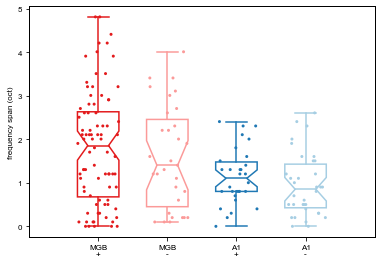

In [5]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
my_order = ['MGB_True', 'MGB_False', 'A1_True', 'A1_False']
palette = MGB_color[:2] + A1_color[:2]
ne['region_sig'] = ne[['region', 'strf_sig']].apply(tuple, axis=1)
ne['region_sig'] = ne['region_sig'].apply(lambda x: '_'.join([str(y) for y in x]))
sns.stripplot(x='region_sig', y='freq_span_oct', data=ne, order=my_order,
              hue='region_sig', hue_order=my_order, palette=palette,
              jitter=0.3, s=3, legend=False)
bplot = sns.boxplot(x='region_sig', y='freq_span_oct', data=ne, order=my_order, 
                    width=0.6, notch=True, flierprops={'marker': ''})
for i,box_col in enumerate(palette):
    
        mybox = bplot.patches[i]
    
        mybox.set_edgecolor(box_col)
        mybox.set_facecolor('w')

        for j in range(i*6,i*6+6):
            line = bplot.lines[j]
            line.set_color(box_col)
            line.set_mfc(box_col)
            line.set_mec(box_col)
xlabels = ['\n'.join(x.split('_')) for x in my_order]
xlabels = [x.replace('True', '+') for x in xlabels]
xlabels = [x.replace('False', '-') for x in xlabels]

ax.set_xticklabels(xlabels)
ax.set_xlim([-1, 4])
ax.set_ylabel('frequency span (oct)')
ax.set_xlabel('')

# significance test between 2 regions
print('significance test: sig vs nonsig')
for i in range(2):
    x=ne[ne['region_sig'] == my_order[i*2]]['freq_span_oct']
    y=ne[ne['region_sig'] == my_order[i*2+1]]['freq_span_oct']
    res = stats.mannwhitneyu(x=x[~np.isnan(x)], 
                            y=y[~np.isnan(y)])
    print(res)
    p = res.pvalue

    plot_significance_star(ax, p, [i*2, i*2+1], 5, 5)
plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\frequency_span_strf_sig.png', bbox_inches='tight', dpi=300)

#### cNE RI vs neuron RI (strf/crh)

MGB: neuron-0.09728416444426323, ne-0.18021815287574106
A1: neuron-0.03415691134875815, ne-0.09628277609725006
MGB: neuron-0.09728416444426323, ne-0.15112456321768236
A1: neuron-0.03415691134875815, ne-0.09866448724234024
MGB: neuron-0.060297093634715554, ne-0.10920838564763967
A1: neuron-0.053125895306850794, ne-0.12376005086418738
MGB: neuron-0.060297093634715554, ne-0.09316590472728899
A1: neuron-0.053125895306850794, ne-0.12279988747091848


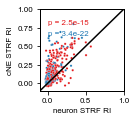

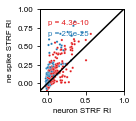

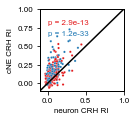

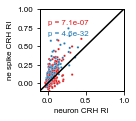

In [13]:
region_colors = [MGB_color[0], A1_color[0]]
regions = ['MGB', 'A1']
sig = 0
data = subsample_summary[(subsample_summary.n_events > 300 )]
for rf in ('strf', 'crh'):
    if sig:
        data = data[eval('data.{}_sig'.format(rf))]
    for ne_param in ('cNE', 'ne_spike'):
        fig = plt.figure()
        plt.plot([-.1, 1], [-.1, 1], 'k')
        sns.scatterplot(data=data, x='{}_ri_neuron_mean'.format(rf), y='{}_ri_{}_mean'.format(rf, ne_param), 
                    hue='region', palette=[MGB_color[0], A1_color[0]], hue_order=['MGB', 'A1'], 
                    s=5, legend=False)
        plt.xlabel('neuron {} RI'.format(rf.upper()))
        plt.ylabel('{} {} RI'.format(ne_param.replace('_', ' '), rf.upper()))
        plt.xlim([-.1, 1])
        plt.ylim([-.1, 1])

        for i, region in enumerate(regions):
            _, p = stats.wilcoxon(x=data[data.region==region]['{}_ri_neuron_mean'.format(rf)], 
                              y=data[data.region==region]['{}_ri_{}_mean'.format(rf, ne_param)])
            plt.text(0, 0.8-0.15*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            print('{}: neuron-{}, ne-{}'.format(region, 
                                        data[data.region==region]['{}_ri_neuron_mean'.format(rf)].mean(), 
                                        data[data.region==region]['{}_ri_{}_mean'.format(rf, ne_param)].mean()))
        fig.set_size_inches(1.5,1.5)
        if sig:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_ri_neuron_vs_{}_sig.jpg'.format(rf, ne_param), bbox_inches='tight', dpi=300)
        else:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_ri_neuron_vs_{}.jpg'.format(rf, ne_param), bbox_inches='tight', dpi=300)


#### strf PTD, crh moranI

MGB: neuron-4.702857376511596, ne-7.188412541112817
A1: neuron-2.9995540034530768, ne-4.644326429492348
MGB: neuron-4.702857376511596, ne-8.202587444468124
A1: neuron-2.9995540034530768, ne-4.954420700566574
MGB: neuron-0.07951399938093895, ne-0.14387997264023472
A1: neuron-0.07787848109373079, ne-0.1684792647263845
MGB: neuron-0.07951399938093895, ne-0.11983870307333332
A1: neuron-0.07787848109373079, ne-0.16344142514173082


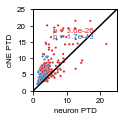

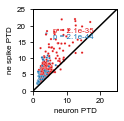

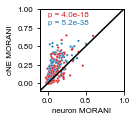

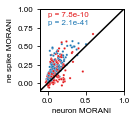

In [39]:
region_colors = [MGB_color[0], A1_color[0]]
regions = ['MGB', 'A1']
sig = 0
data = subsample_summary[(subsample_summary.n_events > 300 )]
param = {'strf': 'ptd', 'crh': 'morani'}
for rf in ['strf', 'crh']:
    if sig:
        data = data[eval('data.{}_sig'.format(rf))]
    for ne_param in ('cNE', 'ne_spike'):
        fig = plt.figure()
        plt.plot([-1, 25], [-1, 25], 'k')
        sns.scatterplot(data=data, x='{}_neuron'.format(param[rf]), y='{}_{}'.format(param[rf], ne_param), 
                    hue='region', palette=[MGB_color[0], A1_color[0]], hue_order=['MGB', 'A1'], 
                    s=5, legend=False)
        plt.xlabel('neuron {}'.format(param[rf].replace('_', ' ').upper()))
        plt.ylabel('{} {}'.format(ne_param.replace('_', ' '), param[rf].replace('_', ' ').upper()))
        if rf == 'strf':
            plt.xlim([0, 25])
            plt.ylim([0, 25])
        else:
            plt.xlim([-.1, 1])
            plt.ylim([-.1, 1])

        for i, region in enumerate(regions):
            _, p = stats.wilcoxon(x=data[data.region==region]['{}_neuron'.format(param[rf])], 
                              y=data[data.region==region]['{}_{}'.format(param[rf], ne_param)])
            if rf == 'strf':
                plt.text(6, 18-2*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            else:
                plt.text(0, .9-.1*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            print('{}: neuron-{}, ne-{}'.format(region, 
                                        data[data.region==region]['{}_neuron'.format(param[rf])].mean(), 
                                        data[data.region==region]['{}_{}'.format(param[rf], ne_param)].mean()))
        fig.set_size_inches(1.5,1.5)
        if sig:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_neuron_vs_{}_sig.jpg'.format(param[rf], ne_param), bbox_inches='tight', dpi=300)
        else:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_neuron_vs_{}.jpg'.format(param[rf], ne_param), bbox_inches='tight', dpi=300)


#### strf nonlinearity (ASI) and mutual information

MGB: neuron-0.9580362894021598, ne-0.9191885599253046
A1: neuron-0.9331509361025, ne-0.8922194112836153
MGB: neuron-0.9580362894021598, ne-0.9372586358812676
A1: neuron-0.9331509361025, ne-0.9013169809783464
MGB: neuron-0.0776624561558686, ne-0.12369954956352117
A1: neuron-0.03052026103450001, ne-0.06805162795869228
MGB: neuron-0.0776624561558686, ne-0.22858948163647896
A1: neuron-0.03052026103450001, ne-0.10209113354419241


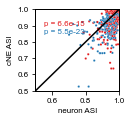

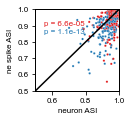

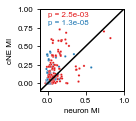

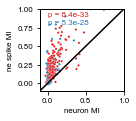

In [43]:
region_colors = [MGB_color[0], A1_color[0]]
regions = ['MGB', 'A1']
sig = 0
data = subsample_summary[(subsample_summary.n_events > 300 )]
for param in ['asi', 'mi']:
    if sig:
        data = data[eval('data.{}_sig'.format(rf))]
    for ne_param in ('cNE', 'ne_spike'):
        fig = plt.figure()
        plt.plot([-1, 25], [-1, 25], 'k')
        sns.scatterplot(data=data, x='{}_neuron'.format(param), y='{}_{}'.format(param, ne_param), 
                    hue='region', palette=[MGB_color[0], A1_color[0]], hue_order=['MGB', 'A1'], 
                    s=5, legend=False)
        plt.xlabel('neuron {}'.format(param.replace('_', ' ').upper()))
        plt.ylabel('{} {}'.format(ne_param.replace('_', ' '), param.replace('_', ' ').upper()))
        if param == 'asi':
            plt.xlim([.5, 1])
            plt.ylim([.5, 1])
        else:
            plt.xlim([-.1, 1])
            plt.ylim([-.1, 1])

        for i, region in enumerate(regions):
            _, p = stats.wilcoxon(x=data[data.region==region]['{}_neuron'.format(param)], 
                              y=data[data.region==region]['{}_{}'.format(param, ne_param)])
            if param == 'asi':
                plt.text(.55, .9-.05*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            else:
                plt.text(0, .9-.1*i, 'p = {:.1e}'.format(p), color=region_colors[i])
            print('{}: neuron-{}, ne-{}'.format(region, 
                                        data[data.region==region]['{}_neuron'.format(param)].mean(), 
                                        data[data.region==region]['{}_{}'.format(param, ne_param)].mean()))
        fig.set_size_inches(1.5,1.5)
        if sig:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_neuron_vs_{}_sig.jpg'.format(param, ne_param), bbox_inches='tight', dpi=300)
        else:
            plt.savefig(r'E:\Congcong\Documents\data\comparison\figure\cNE-properties\{}_neuron_vs_{}.jpg'.format(param, ne_param), bbox_inches='tight', dpi=300)
